# Revealing the turnover strategies of mRNA

This tutorial shows how cellDancer analyzes RNA velocity. The process includes (1) estimating RNA velocity, (2) deriving cell fates on the relative position along the cell cycle of the Geminin-GFP and the Cdt1- RFP signals, and (3) estimating pseudotime.

Below is the case study for metabolic labeling data. We obtain the data from the study of [Battich et al.](https://www.science.org/doi/10.1126/science.aax3072?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed) 3,058 cells with 2,000 genes in pulse experiment are selected.

## Import packages

To run the notebook locally, [Installation](installation.html) could be referred to install the environment and dependencies.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import glob
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import sys

import celldancer as cd
import celldancer.cdplt as cdplt
from celldancer.cdplt import colormap

## Load metabolic labeling data

The input data for cellDancer contains the abundances of unspliced RNA and spliced RNA. For the detail of obtaining the dataset and pre-processing steps, [Data Preparation](data_preprocessing.html) could be referred to. We filter out the genes with the minimum number of 20 counts (both unspliced and spliced) and keep the top 2000 high variable genes. we use 300 nearest neighbors for first-moment calculation.

The data of gastrulation erythroid maturation could be downloaded and unzipped from [GastrulationErythroid_cell_type_u_s.csv.zip](/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/reviewer_rpe1_cell_science_paper/submit_data/RPE1_cell_type_u_s.csv). It could be loaded by ```pd.read_csv('your_path/RPE1_cell_type_u_s.csv')```. To load your own data, the dataframe should contain columns 'gene_name', 'unsplice', 'splice' ,'cellID' ,'clusters' ,'embedding1' , and 'embedding2.' For a detailed description of the data structure, [Data Preparation](data_preprocessing.html) could be referred to.

In [2]:
cellDancer_df_path = '/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/reviewer_rpe1_cell_science_paper/submit_data/RPE1_cell_type_u_s.csv'
cell_type_u_s=pd.read_csv(cellDancer_df_path)
cell_type_u_s

,gene_name,unsplice,splice,cellID,clusters,embedding1,embedding2
0,TSPAN6,0.053717,0.197304,Cell_02365,230.0,3.068787,2.175598
1,TSPAN6,0.062353,0.241826,Cell_02366,66.0,0.636414,2.482727
2,TSPAN6,0.050743,0.172297,Cell_02367,109.0,1.192078,2.804199
3,TSPAN6,0.090908,0.198987,Cell_02368,85.0,0.676575,2.873291
4,TSPAN6,0.053799,0.225365,Cell_02369,177.0,2.468567,3.015930
...,...,...,...,...,...,...,...
6115995,AC125257.1,0.028361,0.182921,Cell_05418,40.0,0.662415,1.963074
6115996,AC125257.1,0.022066,0.121592,Cell_05419,98.0,0.913879,3.048462
6115997,AC125257.1,0.020580,0.114697,Cell_05420,176.0,2.484497,3.111816
6115998,AC125257.1,0.010728,0.181188,Cell_05421,91.0,0.470703,3.241272


## Estimate RNA velocity for sample genes

```cd.velocity()``` could be used to estimate the velocity. 

Here, 10 genes in ```gene_list``` are estimated as an example. By default, the Deep Neural Network (DNN) will be trained at most 200 epochs. It checks the loss every 10 epochs. If the loss has no improvement in 3 checked epochs, the epoch will be ended. The network at that time will be used for the estimation. If supported by equipment, parallel computing could be used to improve the speed, ```n_jobs``` could be adjusted according to demand.

Finally, the predicted unspliced and spliced reads, alpha, beta, and gamma are added to the original dataframe and returned.

In [3]:
gene_list=['KIF11','ANLN','LIMCH1','AURKA','CDC6','NCAPG','CIT','CKS2','CKAP5','TENM3']

loss_df, cellDancer_df=cd.velocity(
                    cell_type_u_s,
                    gene_list=gene_list,
                    speed_up=False,
                    n_jobs=16,
                    )

Using /Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/bin/cellDancer_polish/analysis/reviewer_rpe1_cell_science_paper/cellDancer_velocity_2022-10-15 23-08-47 as the output path.
Arranging genes for parallel job.
10  genes were arranged to  1  portion.



Velocity Estimation: 100%|██████████| 1/1 [00:24<00:00, 24.30s/it]              
                                                                                

## Visualize the phase portraits of sample genes

Let’s visualize the phase portrait of each gene with ```cdplt.scatter_gene()```.

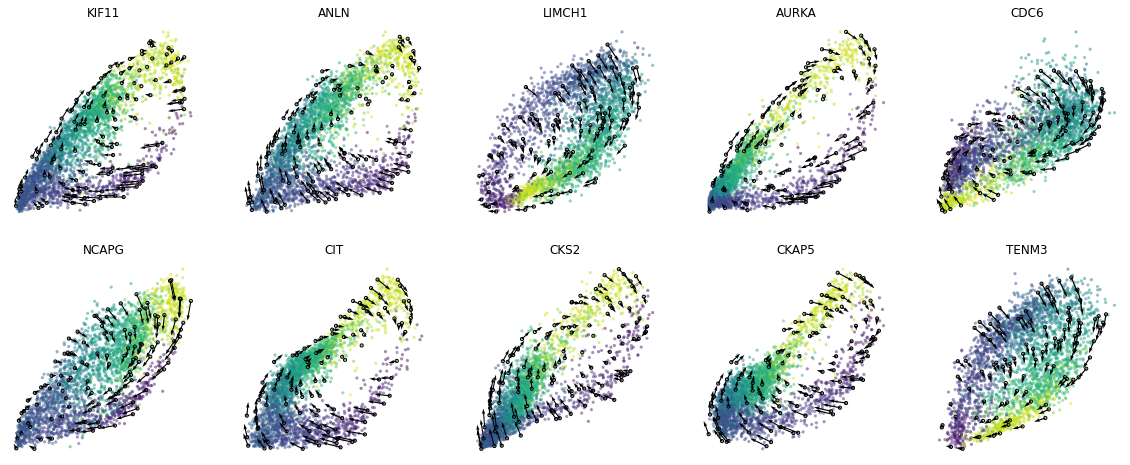

In [4]:
#plot
ncols=5
height=math.ceil(len(gene_list)/ncols)*4
fig = plt.figure(figsize=(20,height))

for i in range(len(gene_list)):
    ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
    cdplt.scatter_gene(
        ax=ax,
        x='splice',
        y='unsplice',
        cellDancer_df=cellDancer_df,
        custom_xlim=None,
        custom_ylim=None,
        colors='clusters',
        alpha=0.5,
        s = 10,
        velocity=True,
        gene=gene_list[i])

    ax.set_title(gene_list[i])
    ax.axis('off')

plt.show()

## Load velocity estimation result of 2,000 genes

To project the prediction of RNA velocity to derive cell fates on the relative position along the cell cycle of the Geminin-GFP and the Cdt1- RFP signals and to estimate pseudotime by using all genes, all the 2,000 genes have already been predicted and could be downloaded and unzipped from [RPE1_cellDancer_estimation_with_cell_velocity_and_time.csv.zip](https://drive.google.com/file/d/1J4GB-Bn2SdmK56wXka5TdvkImspPwIjH/view?usp=sharing). The .csv file could be loaded by ```pd.read_csv()```. The projection of the RNA velocity and pseudotime are already in cellDancer_df. They could be directly visualized. To show how to compute them, we compute them again. If computed again, the existing columns of 'velocity1', 'velocity2', and 'pseudotime' will be replaced.

In [5]:
cellDancer_df_path='/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/data/reviewer_rpe1_cell_science_paper/submit_data/RPE1_cellDancer_estimation_with_cell_velocity_and_time.csv'
cellDancer_df=pd.read_csv(cellDancer_df_path)

## Project the RNA velocity on the relative positions along the cell cycle of the Geminin-GFP and the Cdt1- RFP signals

The projection of RNA velocity in the relative positions along the cell cycle of the Geminin-GFP and the Cdt1- RFP signals could be calculated with ```cd.compute_cell_velocity()```. If not specified, all genes in cellDancer_df will be used to calculate the projection of RNA velocity in the embedding space. We project the velocity vectors of the cells into the low-dimensional embedding space following the method of [velocyto](https://velocyto.org/velocyto.py/index.html#) and [scVelo](https://scvelo.readthedocs.io/).

After the calculation, the projected direction in the embedding space, i.e. columns 'velocity1' and 'velocity2' will be added to the original dataframe. ```cdplt.scatter_cell()``` could display the predicted direction in embedding space.

In [6]:
cellDancer_df=cd.compute_cell_velocity(cellDancer_df=cellDancer_df,
                                       projection_neighbor_choice='gene',
                                       expression_scale=None,
                                       projection_neighbor_size=200,
                                       speed_up=None
                                      )

Caution! Overwriting the 'velocity' columns.


## Estimate pseudotime

Based on the projection of RNA velocity in embedding space, the pseudotime could be estimated with ```cd.pseudo_time()```.

In [7]:
%%capture
import random
# set parameters
dt = 0.05
t_total = {dt:int(10/dt)}
n_repeats = 10

# estimate pseudotime
cellDancer_df = cd.pseudo_time(cellDancer_df=cellDancer_df,
                               grid=(30,30),
                               dt=dt,
                               t_total=t_total[dt],
                               n_repeats=n_repeats,
                               speed_up=(100,100),
                               n_paths = 3,
                               psrng_seeds_diffusion=[i for i in range(n_repeats)],
                               activate_umap_paths_divider=False,
                               n_jobs=8)

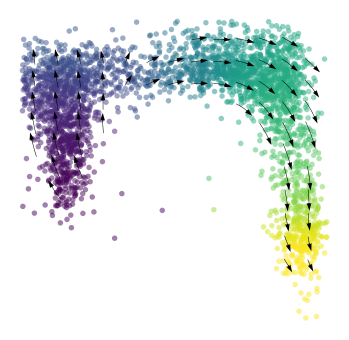

In [8]:
# plot pseudotime

# adjust embedding ranges to ~ (0, 20) for visualization
cellDancer_df_plt=cellDancer_df.copy()
cellDancer_df_plt.loc[:, 'embedding1'] = cellDancer_df_plt['embedding1']/cellDancer_df_plt['embedding1'].max()*20
cellDancer_df_plt.loc[:, 'embedding2'] = cellDancer_df_plt['embedding2']/cellDancer_df_plt['embedding2'].max()*20

fig, ax = plt.subplots(figsize=(6,6))
im = cdplt.scatter_cell(ax,cellDancer_df_plt,
                        colors='pseudotime',
                        alpha=0.5,
                        s=30,
                        velocity=True,
                        legend='off',
                        min_mass=25,
                        arrow_grid=(15,15),
                       colorbar='off')
ax.axis('off')
plt.show()